In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
df = pd.read_csv("../dataset/pm25_missing.txt").drop(['datetime'], axis = 1)
df = df[df.columns[:3]][1000:2000].reset_index(drop=True)
target = torch.tensor(df.values).T.to(device).reshape(3,len(df))
input = torch.tensor(df.index + 1, dtype=float).to(device)

In [4]:
def first_rbf_parameter( target, masking): # done

    # input_data shape : (data_num)
    # target data shape : (3, data_num)
    
    # first layer centers, weights, sigmas
    # centers, sigmas : (3, 10, 1)
    # weights : (3, 1, 10)

    fine_index_target = target.clone().detach()

    find_sigma = masking.clone().detach()
    find_weight = target.clone().detach()
    center_index_list = []

    # first single parameters
    center_index_list = []
    for i in range(10):
        index_ = torch.argmax(torch.abs(torch.nan_to_num(fine_index_target)), dim = 1).reshape(3,1).cpu().detach().tolist()
        for j in range(3):
            fine_index_target[j,index_[j]] = 0.
        center_index_list.append(index_)

    center_index_list = torch.tensor(center_index_list, device= device)
    center_index_list = center_index_list.reshape(10, 3).T

    initcenter = (center_index_list + 1)[:,-10:].T.float()
    
    initweight = []
    for i in range(3):
        initweight.append(torch.index_select(find_weight[i], 0, center_index_list[i][-10:]))
    initweights = torch.concat(initweight).reshape(3, 10)

    initsigma = []
    for i in range(3):
        initsigma.append(torch.index_select(find_sigma[i], 0, center_index_list[i][-10:]))
    initsigmas = torch.concat(initsigma).reshape(10, 3)

    # first MultiRBFs initial sigmas parameters

    return initcenter.reshape(3,10,1), initweights.reshape(3,1,10), initsigmas.reshape(3,10,1)

In [5]:
def time_interval(masking):
    interval = torch.zeros_like(masking)
    for m in range(masking.size(0)):
        for i in range(masking.size(1)):
            after = 0
            before = 0
            after_index = i + 1
            before_index = i - 1
            if i == 0:
                while after == 0 and after_index < masking.size(1):
                    if masking[m][after_index] != 1:
                        after_index += 1
                    else:
                        after = 1
                        interval[m][i] = (after_index - i) / 2
            elif i == masking.size(1)-1:
                while before == 0 and before_index > -1:
                    if masking[m][before_index] != 1:
                        before_index -= 1
                    else:
                        before = 1
                        interval[m][i] = (i - before_index) / 2 
            else:
                after = 0
                before = 0
                while before == 0 and before_index > -1:
                    if masking[m][before_index] != 1:
                        before_index -= 1
                    else:
                        before = 1
                while after == 0 and after_index < masking.size(1):
                    if masking[m][after_index] != 1:
                        after_index += 1
                    else:
                        after = 1
                interval[m][i] = (after_index - before_index) / 2
    return interval

value_masking = torch.where(target.isnan(), 0.0, 1.0).to(torch.float64)
delta = time_interval(value_masking)

In [6]:
initcenter, initweights, initsigmas =  first_rbf_parameter(target, delta)

In [9]:
initcenter.size()

torch.Size([3, 10, 1])

In [10]:
R = torch.exp(-1 *(torch.pow((input - initcenter), 2)) / (torch.pow(initsigmas, 2)))

In [11]:
R.size()

torch.Size([3, 10, 1000])

In [13]:
((-2 *(input - initcenter) / torch.pow(initsigmas,2)) * R).size()

torch.Size([3, 10, 1000])

In [17]:
torch.sum(((-2 *(input - initcenter) / torch.pow(initsigmas,2)) * R) * target.reshape(3, 1, 1000), dim = 2).size()

torch.Size([3, 10])

In [ ]:
def L2_2_derivateive_weight( input_data, radial_output):
    return (-2 *(input_data - centers) / torch.pow(sigma,2)) * radial_output

In [30]:
class SingleRBFNN(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(SingleRBFNN, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []
        self.weights_multi_list = []
        self.centers_multi_list = []
        self.sigma_multi_list = []

        self.change_th = 3

    def first_rbf_parameter(self, target, masking): # done

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (in_feature, add_rbf_num, 1)
        # weights : (in_feature, 1, add_rbf_num)

        fine_index_target = target.clone().detach()

        find_sigma = masking.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first single parameters
        center_index_list = []
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.abs(torch.nan_to_num(fine_index_target)), dim = 1).reshape(self.in_feature,1).cpu().detach().tolist()
            for j in range(self.in_feature):
                fine_index_target[j,index_[j]] = 0.
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= device)
        center_index_list = center_index_list.reshape(self.add_rbf_num, self.in_feature).T

        initcenter = (center_index_list + 1)[:,-self.add_rbf_num:].T.float()
        
        initweight = []
        for i in range(self.in_feature):
            initweight.append(torch.index_select(find_weight[i], 0, center_index_list[i][-self.add_rbf_num:]))
        initweights = torch.concat(initweight).reshape(self.in_feature, self.add_rbf_num)

        initsigma = []
        for i in range(self.in_feature):
            initsigma.append(torch.index_select(find_sigma[i], 0, center_index_list[i][-self.add_rbf_num:]))
        initsigmas = torch.concat(initsigma).reshape(self.add_rbf_num, self.in_feature)

        # first MultiRBFs initial sigmas parameters

        return initcenter.reshape(self.in_feature,self.add_rbf_num,1), initweights.reshape(self.in_feature,1,self.add_rbf_num), initsigmas.reshape(self.in_feature,self.add_rbf_num,1)

    
    def add_rbf_parameter(self, error, masking):
        fine_index_target = error.clone().detach()

        find_sigma = masking.clone().detach()
        find_weight = error.clone().detach()
        center_index_list = []

        # first single parameters
        center_index_list = []
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.abs(torch.nan_to_num(fine_index_target)), dim = 1).reshape(self.in_feature,1).cpu().detach().tolist()
            for j in range(self.in_feature):
                fine_index_target[j,index_[j]] = 0.
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= device)
        center_index_list = center_index_list.reshape(self.add_rbf_num, self.in_feature).T

        initcenter = (center_index_list + 1)[:,-self.add_rbf_num:].T.float()
        
        initweight = []
        for i in range(self.in_feature):
            initweight.append(torch.index_select(find_weight[i], 0, center_index_list[i][-self.add_rbf_num:]))
        initweight = torch.concat(initweight).reshape(self.in_feature, self.add_rbf_num)

        initsigma = []
        for i in range(self.in_feature):
            initsigma.append(torch.index_select(find_sigma[i], 0, center_index_list[i][-self.add_rbf_num:]))
        initsigma = torch.concat(initsigma).reshape(self.add_rbf_num, self.in_feature)

        # first MultiRBFs initial sigmas parameters

        return initcenter.reshape(self.in_feature,self.add_rbf_num,1), initweight.reshape(self.in_feature,1,self.add_rbf_num), initsigma.reshape(self.in_feature,self.add_rbf_num,1)
    
    def masking(self, target):
        
        # value_masking vector
        value_masking = torch.where(target.isnan(), 0.0, 1.0).to(torch.float64)
        
        return value_masking
    
    def time_interval(self, masking):
        interval = torch.zeros_like(masking)
        for m in range(masking.size(0)):
            for i in range(masking.size(1)):
                after = 0
                before = 0
                after_index = i + 1
                before_index = i - 1
                if i == 0:
                    while after == 0 and after_index < masking.size(1):
                        if masking[m][after_index] != 1:
                            after_index += 1
                        else:
                            after = 1
                            interval[m][i] = (after_index - i) / 2
                elif i == masking.size(1)-1:
                    while before == 0 and before_index > -1:
                        if masking[m][before_index] != 1:
                            before_index -= 1
                        else:
                            before = 1
                            interval[m][i] = (i - before_index) / 2 
                else:
                    after = 0
                    before = 0
                    while before == 0 and before_index > -1:
                        if masking[m][before_index] != 1:
                            before_index -= 1
                        else:
                            before = 1
                    while after == 0 and after_index < masking.size(1):
                        if masking[m][after_index] != 1:
                            after_index += 1
                        else:
                            after = 1
                    interval[m][i] = (after_index - before_index) / 2
        return interval
    
    def masking_of_target(self, target, ratio):
        rbf_masking = target.clone().detach()
        indices = torch.nonzero(rbf_masking == 1)  # 배열에서 값이 1인 인덱스 추출
        num_ones = indices.size(0)  # 값이 1인 요소의 개수

        num_zeros_to_replace = int(num_ones * ratio)  # 바꿀 1의 개수 계산
        if num_zeros_to_replace > 0:
            chosen_indices = torch.randperm(num_ones)[:num_zeros_to_replace]  # 바꿀 1의 인덱스를 무작위로 선택

            for index in chosen_indices:
                rbf_masking[indices[index][0], indices[index][1]] = 0  # 선택된 인덱스의 값을 0으로 변경

        return rbf_masking
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.matmul(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (in_feature, add_rbf_num, data_num) 

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (in_feature, add_rbf_num, data_num) 
    

    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data - centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.matmul(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        for i in range(target.size(0)):
            if i == 0:
                f_grad = torch.gradient(target[i], spacing = space, edge_order  = 1)[0]
            else:
                f_grad = torch.vstack([f_grad, torch.gradient(target[i], spacing = space, edge_order  = 1)[0]])
        return f_grad
    
    def target_grad_compute(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights).reshape(f_grad.size(0), f_grad.size(1))
        
        return true_grad

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output
                
    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        
        pred = pred * self.rbf_masking.reshape(self.in_feature, 1, input_data.size(0))
        pred_grad *= self.rbf_masking.reshape(self.in_feature, 1, input_data.size(0))
        target_grad *= self.rbf_masking

        L2_1_error = -2 * (target.reshape(self.in_feature, 1, input_data.size(0)) - pred)
        grad_error = -2 * (target_grad.reshape(self.in_feature, 1, input_data.size(0)) - pred_grad)

        # sigma update 
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error                                                 # (in_feature, add_rbf_num, datalen)
        deltaSigma1 = deltaSigma1 * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)                                    # (in_feature, add_rbf_num, datalen)
        
        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * grad_error
        deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
        
        deltaSigma = (torch.sum(deltaSigma1, dim=2) + torch.sum(deltaSigma2, dim = 2))

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error                                                    # (in_feature, add_rbf_num, datalen)
        deltaCenter1 = deltaCenter1 * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)                                        # (in_feature, add_rbf_num, datalen)
        
        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * grad_error
        deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
        
        deltaCenter =  (torch.sum(deltaCenter1, dim=2) + torch.sum(deltaCenter2)) 
        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)

        delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_data, R) * grad_error, dim = 2)
  
        delta_weight = (delta_weight1 + delta_weight2) 

        # BP update
        self.weights -= self.lr * delta_weight.reshape(self.in_feature, 1 ,self.add_rbf_num)
        self.centers -= self.lr * deltaCenter.reshape(self.in_feature, self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.in_feature, self.add_rbf_num, 1)

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        masking_index = torch.ones_like(self.rbf_masking) - self.rbf_masking
        best_pred_masking = best_pred

        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[i]).cpu().detach().numpy())
                ax[i].scatter(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
                # ax[i].scatter(input_data[self.rbf_masking[i] != 1].cpu().detach().numpy(), best_pred[i][self.rbf_masking[i] != 1].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[0]).cpu().detach().numpy())
            plt.scatter(input_data.cpu().detach().numpy(), best_pred_masking[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?

        rbf_output = torch.exp(-1 *(torch.pow((input_data - best_center), 2)) / (torch.pow(best_sigma, 2)))
        pred = torch.matmul(best_weight, rbf_output)

        return pred
    
    def value_loss(self, pred, target):
        pred = pred.reshape(self.in_feature, pred.size(-1)) * self.value_masking
        return torch.sum(torch.abs(pred - target)) /torch.sum(self.value_masking)
    
    def gradinet_loss(self, pred_grad, true_grad):
        
        pred_grad = pred_grad.reshape(self.in_feature, pred_grad.size(-1)) * self.value_masking
        return torch.sum(torch.abs(pred_grad - true_grad)) /torch.sum(self.value_masking)
    
    def Loss(self, pred, target, pred_grad, target_grad):
        # value L2 loss
        x_loss = self.value_loss(pred, target) + self.gradinet_loss(pred_grad, target_grad)
        return x_loss
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.matmul(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th, masking_rate = 0.5):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.value_masking = self.masking(self.target)

                self.rbf_masking = self.masking_of_target(self.value_masking, masking_rate)
                time_inter = self.time_interval(self.rbf_masking)
                self.step_target = torch.nan_to_num(self.target) * self.rbf_masking
                first_grad = torch.nan_to_num(self.first_grad(input_data, self.target))

                self.centers, self.weights, self.sigma = self.first_rbf_parameter(self.step_target, time_inter)
                
                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights) 

                    self.BP(input_data, self.step_target, R, pred, first_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights) 
                    epoch_loss = self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MAE Loss: {}".format(self.number, epoch, epoch_loss))
                        print("{}th additional RBFlayer {}th epoch value MAE Loss: {}".format(self.number, epoch, self.value_loss(pred, torch.nan_to_num(self.target))))
                        print("{}th additional RBFlayer {}th epoch gradient MAE Loss: {}".format(self.number, epoch, self.gradinet_loss(rbf_grad, first_grad)))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break

                # rbf_masking
                self.rbf_masking = self.masking_of_target(self.value_masking, masking_rate)
                self.step_target = torch.nan_to_num(self.target) * self.rbf_masking
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(self.step_target, time_inter)
                for epoch in range(epochs):
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights) 
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, self.target_grad)))
                        self.best_loss = self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, self.target_grad)
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.step_target, R, pred, self.target_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, self.target_grad)

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MAE Loss: {}".format(self.number, epoch, epoch_loss))
                        print("{}th additional RBFlayer {}th epoch value MAE Loss: {}".format(self.number, epoch, self.value_loss(pred, torch.nan_to_num(self.target))))
                        print("{}th additional RBFlayer {}th epoch gradient MAE Loss: {}".format(self.number, epoch, self.gradinet_loss(rbf_grad, first_grad)))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()

                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            
            
            if self.number ==0:
                train_loss = self.Loss(best_pred, torch.nan_to_num(self.target), rbf_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, torch.nan_to_num(self.target), rbf_grad, self.target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.3
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred.reshape(self.in_feature, best_pred.size(-1)))

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred.reshape(self.in_feature, best_pred.size(-1))  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  = 1)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 1)
                self.done_weights = torch.cat(self.weights_list, dim = 2)
                self.target_grad = self.target_grad_compute(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0

In [65]:
df = pd.read_csv("../dataset/pm25_missing.txt").drop(['datetime'], axis = 1)
df = df[df.columns[3]][1000:2000].reset_index(drop=True)
target = torch.tensor(df.values).T.to(device).reshape(1,len(df))
input = torch.tensor(df.index + 1, dtype=float).to(device)
model = SingleRBFNN(1, 100, device)
model.train(input, target, 3000, 1e-4, 10, 20, 0.0)

0th additional rbflayer


RuntimeError: output with shape [1000] doesn't match the broadcast shape [1, 1000]

In [40]:
class MultiRBFnnTime(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnnTime, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target, masking): # done

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = masking.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                

        initsigma = torch.index_select(find_sigma, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        # initsigma += torch.rand_like(initsigma)

        # print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error, masking):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = masking.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        initsigma = torch.index_select(find_sigma, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        return initcenter, initweight, initsigma
    
    def masking_of_target(self, target, ratio):
        rbf_masking = target.clone().detach()
        indices = torch.nonzero(rbf_masking == 1)  # 배열에서 값이 1인 인덱스 추출
        num_ones = indices.size(0)  # 값이 1인 요소의 개수

        num_zeros_to_replace = int(num_ones * ratio)  # 바꿀 1의 개수 계산
        if num_zeros_to_replace > 0:
            chosen_indices = torch.randperm(num_ones)[:num_zeros_to_replace]  # 바꿀 1의 인덱스를 무작위로 선택

            for index in chosen_indices:
                rbf_masking[indices[index][0], indices[index][1]] = 0  # 선택된 인덱스의 값을 0으로 변경

        return rbf_masking
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        for i in range(target.size(0)):
            if i == 0:
                f_grad = torch.gradient(target[i], spacing = space, edge_order  = 1)[0]
            else:
                f_grad = torch.vstack([f_grad, torch.gradient(target[i], spacing = space, edge_order  = 1)[0]])
        return f_grad
    
    def target_grad_compute(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output
    
    def masking(self, target):
    
        # value_masking vector
        value_masking = torch.where(target.isnan(), 0.0, 1.0).to(torch.float64)
        
        return value_masking
    
    def time_interval(self, masking):
        interval = torch.zeros_like(masking)
        for m in range(masking.size(0)):
            for i in range(masking.size(1)):
                after = 0
                before = 0
                after_index = i + 1
                before_index = i - 1
                if i == 0:
                    while after == 0 and after_index < masking.size(1):
                        if masking[m][after_index] != 1:
                            after_index += 1
                        else:
                            after = 1
                            interval[m][i] = (after_index - i) / 2
                elif i == masking.size(1)-1:
                    while before == 0 and before_index > -1:
                        if masking[m][before_index] != 1:
                            before_index -= 1
                        else:
                            before = 1
                            interval[m][i] = (i - before_index) / 2 
                else:
                    after = 0
                    before = 0
                    while before == 0 and before_index > -1:
                        if masking[m][before_index] != 1:
                            before_index -= 1
                        else:
                            before = 1
                    while after == 0 and after_index < masking.size(1):
                        if masking[m][after_index] != 1:
                            after_index += 1
                        else:
                            after = 1
                    interval[m][i] = (after_index - before_index) / 2
        return torch.mean(interval, axis = 0)
                
    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):

        pred = pred * self.rbf_masking
        pred_grad = pred_grad * self.rbf_masking

        L2_1_error = -2 * (target - pred)

        L2_2_error = -2 * (target_grad - pred_grad)

        observation_len = torch.sum(self.rbf_masking)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        # deltaSigma =  torch.mean(torch.sum(deltaSigma1, dim=2), dim = 0) + torch.mean(torch.sum(deltaSigma2, dim=2), dim = 0)
        deltaSigma = torch.sum(torch.sum(deltaSigma1, dim=2), dim = 0) / observation_len + torch.sum(torch.sum(deltaSigma2, dim=2), dim = 0) / observation_len

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
        
        # deltaCenter =  torch.mean(torch.sum(deltaCenter1, dim=2), dim = 0) + torch.mean(torch.sum(deltaCenter2, dim=2), dim = 0)
        deltaCenter =  torch.sum(torch.sum(deltaCenter1, dim=2), dim = 0) / observation_len + torch.sum(torch.sum(deltaCenter2, dim=2), dim = 0) / observation_len
        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_data, R) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0)), dim = 2)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.weights -= self.lr * delta_weight / observation_len
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        masking_index = torch.ones_like(self.rbf_masking) - self.rbf_masking
        best_pred_masking = best_pred
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[i]).cpu().detach().numpy())
                ax[i].scatter(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
                ax[i].scatter(input_data[masking_index[i] != 1].cpu().detach().numpy(), best_pred[i][masking_index[i] != 1].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[0]).cpu().detach().numpy())
            plt.scatter(input_data.cpu().detach().numpy(), best_pred_masking[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  
        pred *= self.value_masking
        pred_grad *= self.value_masking

        x_loss = 0
        x_loss += self.value_loss(pred, target)
        x_loss += self.gradinet_loss(pred_grad, true_grad) 

        return x_loss
    
    def value_loss(self, pred, target):
        # pred = pred * self.value_masking
        return torch.sum(torch.abs(pred - target)) /torch.sum(self.value_masking)
    
    def gradinet_loss(self, pred_grad, true_grad):
        # pred_grad *= self.value_masking
        return torch.sum(torch.abs(pred_grad - true_grad)) /torch.sum(self.value_masking)
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th, masking_rate = 0.5):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.value_masking = self.masking(self.target)

                self.rbf_masking = self.masking_of_target(self.value_masking, masking_rate)
                time_inter = self.time_interval(self.rbf_masking)
                self.step_target = torch.nan_to_num(self.target) * self.rbf_masking


                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.step_target, time_inter)
                first_grad = torch.nan_to_num(self.first_grad(input_data, self.target))
                self.step_grad = torch.nan_to_num(self.first_grad(input_data, self.step_target))

                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights) 

                    self.BP(input_data, self.step_target, R, pred, self.step_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights) 
                    epoch_loss = self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                        print("{}th additional RBFlayer {}th epoch value MAE Loss: {}".format(self.number, epoch, self.value_loss(pred, torch.nan_to_num(self.target))))
                        print("{}th additional RBFlayer {}th epoch gradient MAE Loss: {}".format(self.number, epoch, self.gradinet_loss(rbf_grad, first_grad)))
                    
                # print(self.sigma)

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break

                # rbf_masking
                self.rbf_masking = self.masking_of_target(self.value_masking, masking_rate)
                self.step_target = torch.nan_to_num(self.target) * self.rbf_masking
                self.step_grad = torch.nan_to_num(self.first_grad(input_data, self.step_target))
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.step_target, time_inter)
                # print(self.sigma)
                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, self.target_grad)))
                        self.best_loss = self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, self.target_grad.clone().detach())
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.step_target, R, pred, self.step_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, self.target_grad)

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                        print("{}th additional RBFlayer {}th epoch value MAE Loss: {}".format(self.number, epoch, self.value_loss(pred, torch.nan_to_num(self.target))))
                        print("{}th additional RBFlayer {}th epoch gradient MAE Loss: {}".format(self.number, epoch, self.gradinet_loss(rbf_grad, torch.nan_to_num(self.target_grad))))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, torch.nan_to_num(self.target), best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, torch.nan_to_num(self.target), best_grad, self.target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.3
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                self.target_grad = self.target_grad_compute(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 75.37673095306394
0th additional RBFlayer 999th epoch MSE Loss: 54.58907116711532
0th additional RBFlayer 999th epoch value MAE Loss: 46.997860920827534
0th additional RBFlayer 999th epoch gradient MAE Loss: 7.591210246287789
0th additional RBFlayer 1999th epoch MSE Loss: 54.42508058785335
0th additional RBFlayer 1999th epoch value MAE Loss: 46.46113205714945
0th additional RBFlayer 1999th epoch gradient MAE Loss: 7.963948530703903
0th additional RBFlayer 2999th epoch MSE Loss: 52.731876627454355
0th additional RBFlayer 2999th epoch value MAE Loss: 44.667658889562084
0th additional RBFlayer 2999th epoch gradient MAE Loss: 8.06421773789227
0th additional RBFlayer best loss : 52.383402084798895


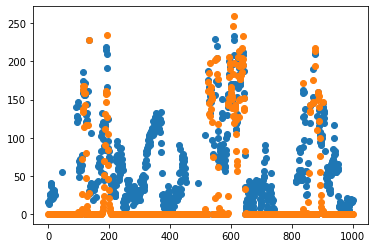

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 54.61581511244531
1th additional RBFlayer 999th epoch MSE Loss: 41.11203599302584
1th additional RBFlayer 999th epoch value MAE Loss: 30.12529024539314
1th additional RBFlayer 999th epoch gradient MAE Loss: 10.986745747632705
1th additional RBFlayer 1999th epoch MSE Loss: 40.05848146982145
1th additional RBFlayer 1999th epoch value MAE Loss: 29.364852028354868
1th additional RBFlayer 1999th epoch gradient MAE Loss: 10.693629441466582
1th additional RBFlayer 2999th epoch MSE Loss: 39.5057974706336
1th additional RBFlayer 2999th epoch value MAE Loss: 28.705776866577686
1th additional RBFlayer 2999th epoch gradient MAE Loss: 10.800020604055916
1th additional RBFlayer best loss : 39.5057974706336


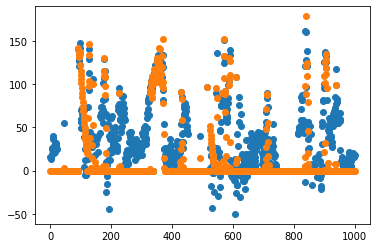

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 38.44649934824685
2th additional RBFlayer 999th epoch MSE Loss: 32.191123864159685
2th additional RBFlayer 999th epoch value MAE Loss: 19.994496194355825
2th additional RBFlayer 999th epoch gradient MAE Loss: 12.19662766980386
2th additional RBFlayer 1999th epoch MSE Loss: 31.894290018688306
2th additional RBFlayer 1999th epoch value MAE Loss: 20.117002815714038
2th additional RBFlayer 1999th epoch gradient MAE Loss: 11.777287202974268
2th additional RBFlayer 2999th epoch MSE Loss: 31.716543479702615
2th additional RBFlayer 2999th epoch value MAE Loss: 20.000011243634155
2th additional RBFlayer 2999th epoch gradient MAE Loss: 11.71653223606846
2th additional RBFlayer best loss : 31.67164945520182


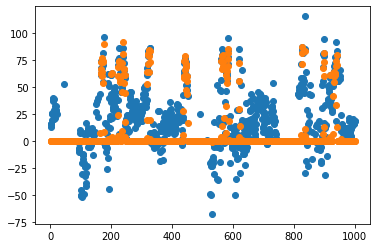

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 31.266234252935956
3th additional RBFlayer 999th epoch MSE Loss: 26.37422736750036
3th additional RBFlayer 999th epoch value MAE Loss: 13.739248200379711
3th additional RBFlayer 999th epoch gradient MAE Loss: 12.634979167120648
3th additional RBFlayer 1999th epoch MSE Loss: 26.157611517387984
3th additional RBFlayer 1999th epoch value MAE Loss: 13.738086034352566
3th additional RBFlayer 1999th epoch gradient MAE Loss: 12.419525483035416
3th additional RBFlayer 2999th epoch MSE Loss: 26.122326136854184
3th additional RBFlayer 2999th epoch value MAE Loss: 13.900723984262184
3th additional RBFlayer 2999th epoch gradient MAE Loss: 12.221602152592002
3th additional RBFlayer best loss : 26.122326136854184
change lr  0.001
----------------------------------------------


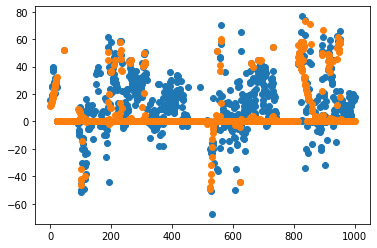

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 25.308636540654852
4th additional RBFlayer 999th epoch MSE Loss: 23.57570278302469
4th additional RBFlayer 999th epoch value MAE Loss: 10.501305832352857
4th additional RBFlayer 999th epoch gradient MAE Loss: 13.074396950671833
4th additional RBFlayer 1999th epoch MSE Loss: 23.374294189314643
4th additional RBFlayer 1999th epoch value MAE Loss: 10.394037087919108
4th additional RBFlayer 1999th epoch gradient MAE Loss: 12.980257101395535
4th additional RBFlayer 2999th epoch MSE Loss: 23.120793012543544
4th additional RBFlayer 2999th epoch value MAE Loss: 10.192328887486502
4th additional RBFlayer 2999th epoch gradient MAE Loss: 12.928464125057042
4th additional RBFlayer best loss : 22.45494749446089


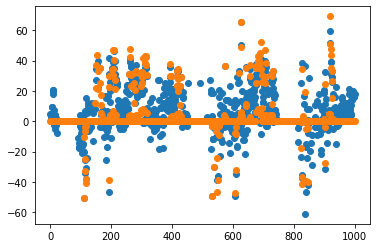

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 21.82755460580689
5th additional RBFlayer 999th epoch MSE Loss: 20.42359532749091
5th additional RBFlayer 999th epoch value MAE Loss: 7.104987900700759
5th additional RBFlayer 999th epoch gradient MAE Loss: 13.318607426790154
5th additional RBFlayer 1999th epoch MSE Loss: 20.288623066304464
5th additional RBFlayer 1999th epoch value MAE Loss: 7.037739642432577
5th additional RBFlayer 1999th epoch gradient MAE Loss: 13.250883423871887
5th additional RBFlayer 2999th epoch MSE Loss: 20.223290748377487
5th additional RBFlayer 2999th epoch value MAE Loss: 6.968152162280658
5th additional RBFlayer 2999th epoch gradient MAE Loss: 13.255138586096827
5th additional RBFlayer best loss : 20.16009703128809


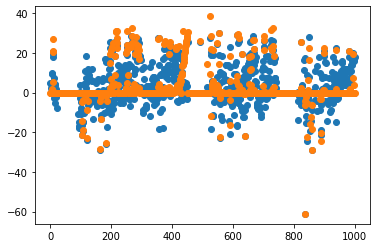

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 19.1475105675583
6th additional RBFlayer 999th epoch MSE Loss: 18.22783924503128
6th additional RBFlayer 999th epoch value MAE Loss: 4.465741117569257
6th additional RBFlayer 999th epoch gradient MAE Loss: 13.762098127462023
6th additional RBFlayer 1999th epoch MSE Loss: 18.25698744694092
6th additional RBFlayer 1999th epoch value MAE Loss: 4.672149689349098
6th additional RBFlayer 1999th epoch gradient MAE Loss: 13.58483775759182
6th additional RBFlayer 2999th epoch MSE Loss: 18.23539408762851
6th additional RBFlayer 2999th epoch value MAE Loss: 4.703102230572104
6th additional RBFlayer 2999th epoch gradient MAE Loss: 13.532291857056405
6th additional RBFlayer best loss : 18.0758635524948


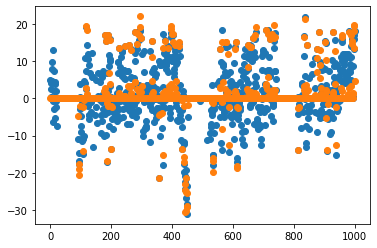

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 17.38697704871148
7th additional RBFlayer 999th epoch MSE Loss: 16.683967225959414
7th additional RBFlayer 999th epoch value MAE Loss: 2.9556188826134004
7th additional RBFlayer 999th epoch gradient MAE Loss: 13.728348343346015
7th additional RBFlayer 1999th epoch MSE Loss: 16.77457969055877
7th additional RBFlayer 1999th epoch value MAE Loss: 3.019330988608058
7th additional RBFlayer 1999th epoch gradient MAE Loss: 13.75524870195071
7th additional RBFlayer 2999th epoch MSE Loss: 16.757276416847077
7th additional RBFlayer 2999th epoch value MAE Loss: 3.0703809193021776
7th additional RBFlayer 2999th epoch gradient MAE Loss: 13.6868954975449
7th additional RBFlayer best loss : 16.667455708053385


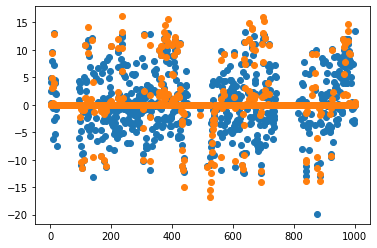

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 16.56237314015032
8th additional RBFlayer 999th epoch MSE Loss: 16.23262362834172
8th additional RBFlayer 999th epoch value MAE Loss: 2.225223398985141
8th additional RBFlayer 999th epoch gradient MAE Loss: 14.00740022935658
8th additional RBFlayer 1999th epoch MSE Loss: 16.122582437536884
8th additional RBFlayer 1999th epoch value MAE Loss: 2.1572121153418276
8th additional RBFlayer 1999th epoch gradient MAE Loss: 13.965370322195056
8th additional RBFlayer 2999th epoch MSE Loss: 16.10382274913371
8th additional RBFlayer 2999th epoch value MAE Loss: 2.155580880666906
8th additional RBFlayer 2999th epoch gradient MAE Loss: 13.948241868466802
8th additional RBFlayer best loss : 16.103718439246165


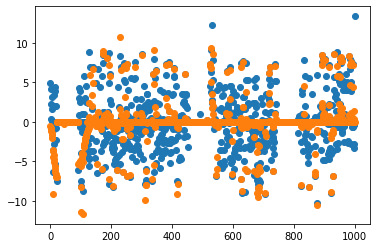

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 16.073763106013466
9th additional RBFlayer 999th epoch MSE Loss: 15.940283743365065
9th additional RBFlayer 999th epoch value MAE Loss: 1.6748192132746818
9th additional RBFlayer 999th epoch gradient MAE Loss: 14.265464530090382
9th additional RBFlayer 1999th epoch MSE Loss: 15.820437527913127
9th additional RBFlayer 1999th epoch value MAE Loss: 1.6037633863141905
9th additional RBFlayer 1999th epoch gradient MAE Loss: 14.216674141598936
9th additional RBFlayer 2999th epoch MSE Loss: 15.748797391062428
9th additional RBFlayer 2999th epoch value MAE Loss: 1.56582189755289
9th additional RBFlayer 2999th epoch gradient MAE Loss: 14.182975493509538
9th additional RBFlayer best loss : 15.748797391062428


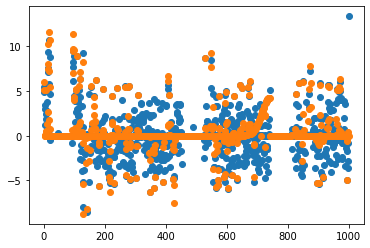

10th additional rbflayer
10th additional RBFlayer 0th epoch loss: 15.493507844656698
10th additional RBFlayer 999th epoch MSE Loss: 15.471508176086934
10th additional RBFlayer 999th epoch value MAE Loss: 1.127558453454426
10th additional RBFlayer 999th epoch gradient MAE Loss: 14.343949722632507
10th additional RBFlayer 1999th epoch MSE Loss: 15.423628140790772
10th additional RBFlayer 1999th epoch value MAE Loss: 1.0891498902088503
10th additional RBFlayer 1999th epoch gradient MAE Loss: 14.334478250581922
10th additional RBFlayer 2999th epoch MSE Loss: 15.385682256080484
10th additional RBFlayer 2999th epoch value MAE Loss: 1.0612331415028726
10th additional RBFlayer 2999th epoch gradient MAE Loss: 14.324449114577611
10th additional RBFlayer best loss : 15.385682256080484


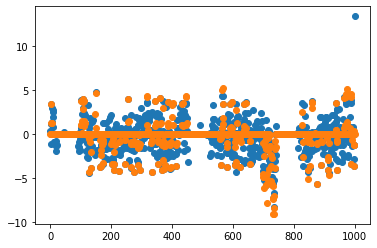

11th additional rbflayer
11th additional RBFlayer 0th epoch loss: 15.305611845706174
11th additional RBFlayer 999th epoch MSE Loss: 15.316000185504452
11th additional RBFlayer 999th epoch value MAE Loss: 0.8366929168597541
11th additional RBFlayer 999th epoch gradient MAE Loss: 14.479307268644698
11th additional RBFlayer 1999th epoch MSE Loss: 15.299674190477253
11th additional RBFlayer 1999th epoch value MAE Loss: 0.8205717138402385
11th additional RBFlayer 1999th epoch gradient MAE Loss: 14.479102476637015
11th additional RBFlayer 2999th epoch MSE Loss: 15.28271350141676
11th additional RBFlayer 2999th epoch value MAE Loss: 0.805023921781791
11th additional RBFlayer 2999th epoch gradient MAE Loss: 14.47768957963497
11th additional RBFlayer best loss : 15.28271350141676


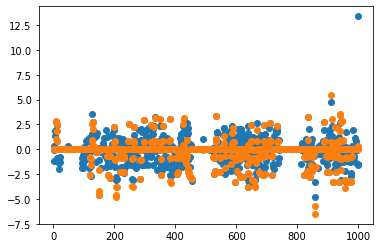

12th additional rbflayer
12th additional RBFlayer 0th epoch loss: 15.13821564884168
12th additional RBFlayer 999th epoch MSE Loss: 15.157883155773755
12th additional RBFlayer 999th epoch value MAE Loss: 0.6266090792646797
12th additional RBFlayer 999th epoch gradient MAE Loss: 14.531274076509074
12th additional RBFlayer 1999th epoch MSE Loss: 15.151373303760247
12th additional RBFlayer 1999th epoch value MAE Loss: 0.6189572723789653
12th additional RBFlayer 1999th epoch gradient MAE Loss: 14.532416031381281
12th additional RBFlayer 2999th epoch MSE Loss: 15.145145618175096
12th additional RBFlayer 2999th epoch value MAE Loss: 0.611674541337078
12th additional RBFlayer 2999th epoch gradient MAE Loss: 14.533471076838019
12th additional RBFlayer best loss : 15.13821564884168


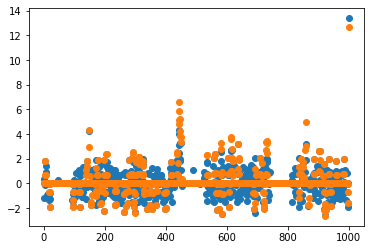

13th additional rbflayer
13th additional RBFlayer 0th epoch loss: 15.09563813533547
13th additional RBFlayer 999th epoch MSE Loss: 15.091647896477612
13th additional RBFlayer 999th epoch value MAE Loss: 0.511678834268921
13th additional RBFlayer 999th epoch gradient MAE Loss: 14.579969062208692
13th additional RBFlayer 1999th epoch MSE Loss: 15.087878992267722
13th additional RBFlayer 1999th epoch value MAE Loss: 0.5071399599876522
13th additional RBFlayer 1999th epoch gradient MAE Loss: 14.58073903228007
13th additional RBFlayer 2999th epoch MSE Loss: 15.08425262382512
13th additional RBFlayer 2999th epoch value MAE Loss: 0.5027741258789931
13th additional RBFlayer 2999th epoch gradient MAE Loss: 14.581478497946128
13th additional RBFlayer best loss : 15.08425262382512


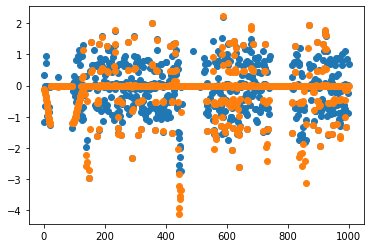

14th additional rbflayer
14th additional RBFlayer 0th epoch loss: 15.04184640332627
14th additional RBFlayer 999th epoch MSE Loss: 15.039909369184446
14th additional RBFlayer 999th epoch value MAE Loss: 0.4083074915869907
14th additional RBFlayer 999th epoch gradient MAE Loss: 14.631601877597456
14th additional RBFlayer 1999th epoch MSE Loss: 15.037982012634462
14th additional RBFlayer 1999th epoch value MAE Loss: 0.406369952850827
14th additional RBFlayer 1999th epoch gradient MAE Loss: 14.631612059783635
14th additional RBFlayer 2999th epoch MSE Loss: 15.036055947073587
14th additional RBFlayer 2999th epoch value MAE Loss: 0.4044484134289068
14th additional RBFlayer 2999th epoch gradient MAE Loss: 14.63160753364468
14th additional RBFlayer best loss : 15.036055947073587


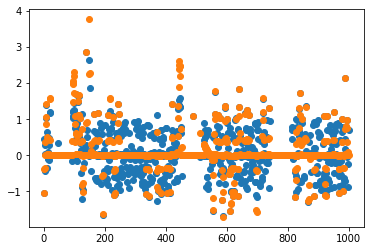

15th additional rbflayer
15th additional RBFlayer 0th epoch loss: 14.990634263218562
15th additional RBFlayer 999th epoch MSE Loss: 14.987604136231612
15th additional RBFlayer 999th epoch value MAE Loss: 0.3501200104521761
15th additional RBFlayer 999th epoch gradient MAE Loss: 14.637484125779435
15th additional RBFlayer 1999th epoch MSE Loss: 14.984727329256758
15th additional RBFlayer 1999th epoch value MAE Loss: 0.3471116460361924
15th additional RBFlayer 1999th epoch gradient MAE Loss: 14.637615683220567
15th additional RBFlayer 2999th epoch MSE Loss: 14.98205323488878
15th additional RBFlayer 2999th epoch value MAE Loss: 0.34431203542844363
15th additional RBFlayer 2999th epoch gradient MAE Loss: 14.637741199460336
15th additional RBFlayer best loss : 14.98205323488878


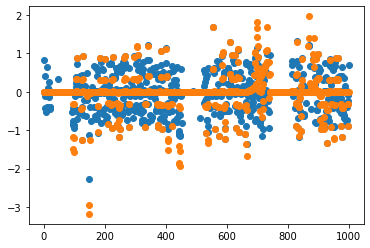

In [66]:
df = pd.read_csv("../dataset/pm25_missing.txt").drop(['datetime'], axis = 1)
df = df[df.columns[3]][1000:2000].reset_index(drop=True)
target = torch.tensor(df.values).T.to(device).reshape(1,len(df))
input = torch.tensor(df.index + 1, dtype=float).to(device)
model = MultiRBFnnTime(1, 100, device)
model.train(input, target, 3000, 1e-4, 15, 30, 0.0)

In [ ]:
pred = model.pred(input)[1]

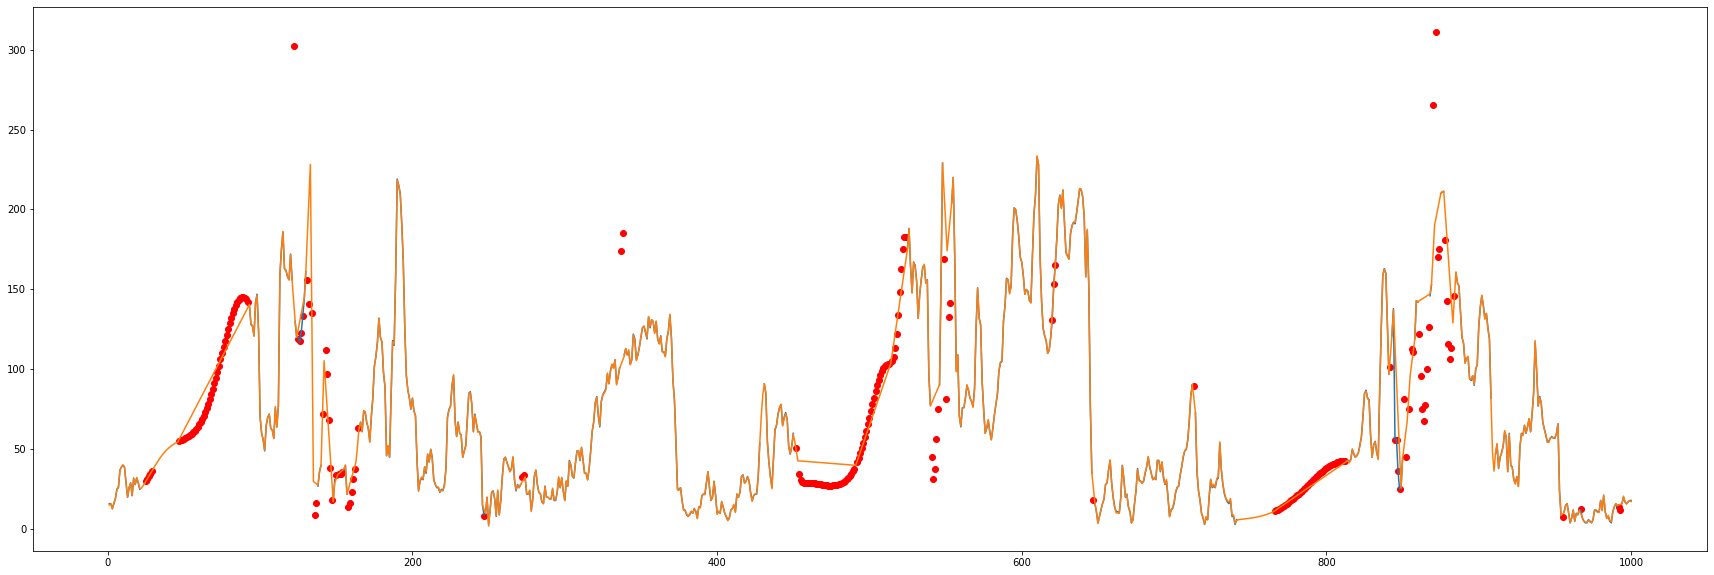

In [68]:
pred = model.pred(input)[1]
for i in range(1):
    plt.figure(figsize=(30, 10))
    plt.plot(input.cpu().detach().numpy(), target[i].cpu().detach().numpy())
    plt.plot(input[missing_index[i] != 1].cpu().detach().numpy(), pred[i][missing_index[i] != 1].cpu().detach().numpy())
    plt.scatter(input[missing_index[i] != 0].cpu().detach().numpy(), pred[i][missing_index[i] != 0].cpu().detach().numpy(), c = 'Red')
    plt.show()

In [ ]:
class MultiRBF(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBF, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device

        self.model_list = self.bulid()
    
    def bulid(self):
        model_list = []

        for i in range(self.in_feature):
            model = MultiRBFnnTime(1, self.add_rbf_num, device)
            model_list.append(model)

        return model_list

    